# Perceptron Learning Algorithm (Binary Classifier)

### Modification History
\>\>\> ZJ Zhang (Jan 23th, 2018) 
<br>
\>\>\> ZJ Zhang (Jan 24th, 2018) --- (ADD - Section4)
<br>
\>\>\> ZJ Zhang (Jan 25th, 2018) --- (ADD - Convergence Test)
<br>
\>\>\> ZJ Zhang (Jan 26th, 2018) --- (REVISE - Fix a typo in the figure title)

<a id='section1'></a>
## 1. Overview
Given $N$ input vectors with $D$ dimensions as training data, with each noted as $\boldsymbol{x_{i}}$ and known labels of $l_{i}$ (binary values of $-1$ or $1$), I will build a perceptron that the output of each $\boldsymbol{x_{i}}$ is exactly its corresponding label of $l_{i}$. Each vector $\boldsymbol{x_{i}}$ could be expressed as
<br>
$$
\boldsymbol{x_{i}} = (x_{i,1}, x_{i,2}, ..., x_{i,D})
$$
with each element termed $x_{i,j}$ ($j=1,2,...,D$)

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Formating 
matplotlib.rcParams['axes.linewidth'] = 2
_ = np.seterr(divide='ignore', invalid='ignore')

<a id='section2'></a>
## 2. Training Data
Training data are created by prior knowledge. I assume there are $N$ vectors (or points) serving as training data, randomly distributed within a $D$-dimensional sphere with a radius of $R$. Then I assign them labels based on a linear boundary, described by 
<br>
$$
p_{0} + p_{1}x_{1} + p_{2}x_{2} + ... + p_{D}x_{D} = 0 \quad \Rightarrow \quad \boldsymbol{p}\cdot\boldsymbol{x}=0
$$
where,
<br>
$$
\boldsymbol{p} = (p_{0}, p_{1}, p_{2}, ..., p_{D}) \quad \boldsymbol{x} = (1, x_{1}, x_{2}, ..., x_{D})
$$

**If an vector point is above the boundary, then I assign a label of $1$, otherwise (i.e., below or right on the boundary), I assign a label of $-1$.**

Here I assume all data are uniformly distributed in the hypersphere. In addition, the boundary parameters $\boldsymbol{p}$ are generated randomly within $[p_{\rm min}, p_{\rm max}]$ with a dimension of $D+1$. The following parameters are defiend by the user: $N$, $D$, $R$, $p_{\rm bound} = [p_{\rm min}, p_{\rm max}]$. 

In [2]:
## metric of the training data - defined by the user
Nd = 100 # number of vectors/points
Dd = 2   # dimension
Rd = 10  # radius of the hypersphere where all data are distributed
p_bound = [-10, 10]  # extent of the boundary parameters

# generate the prior boundary parameter p
p_param = np.random.uniform(low=p_bound[0], high=p_bound[-1], size=Dd+1)
p_param[0] *= 2

In [3]:
## training data generation
Train_Data = np.random.uniform(low=-Rd, high=Rd, size=(Nd,Dd+1))
Train_Data[:,0] = 1.0  # append a 1.0 to the beginning of each vectors' coordinates
# assign labels based on points' position compared to the prior boundary
Train_Label = np.sign(np.sum(Train_Data*p_param, axis=1))  

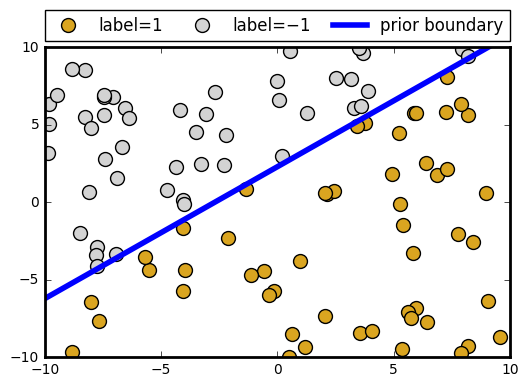

In [4]:
## plot the training data and the prior boundary - for 2D only
if Dd==2:
    # marker geometry
    marker = 'o'
    markersize = 10
    markeredgewidth = 1
    # colors
    pos_color = 'goldenrod'
    neg_color = 'lightgrey'
    edgecolor = 'k'
    # lines
    marker_linestyle = 'None'
    bound_linestyle = '-'
    bound_linewdith = 4
    prbound_color = 'blue'
    # plot points with different labels
    pos_id = np.where(Train_Label==1)[0]
    plt.plot(Train_Data[pos_id,1], Train_Data[pos_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=pos_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label='label=1')
    neg_id = np.where(Train_Label==-1)[0]
    plt.plot(Train_Data[neg_id,1], Train_Data[neg_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=neg_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label=u'label=\u22121')
    # plot the prior boundary
    x_bound = np.linspace(-Rd, Rd,2)
    y_prbound = -1.0 * (p_param[0] + p_param[1]*x_bound) / p_param[2]
    plt.plot(x_bound, y_prbound, color=prbound_color, linestyle=bound_linestyle, 
             linewidth=bound_linewdith, label='prior boundary')
    # limits and label
    plt.xlim([-Rd, Rd])
    plt.ylim([-Rd, Rd])
    # legend
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, numpoints=1, mode="expand", borderaxespad=0.)

<a id='section3'></a>
## 3. Algorithm
The perceptron learning is actually to find the (linear) boundary that separate the vectors/points with two labels, given the training data. The whole algorithm include the following steps:

1) Initialize a boundary parameter $\boldsymbol{w_{0}}$, weights.
<br>
2) For misclassified examples (e.g., $\boldsymbol{x_{j}}$ whose $l_{j} \neq y_{j}$), compute the classifier output ($y_{j}$) and update the weights based on $\boldsymbol{w} += c (l_{j} - y_{j}) \boldsymbol{x_{j}}$, where $c$ is the learning rate.
<br>
3) Iterate among all of the training data until the output classification of all data match their own labels.

<a id='section3.1'></a>
### 3.1 Convergence Limit
If the training data are intrinsically not linearly separable, then we need a maximum effective iteration times as a tolerance, i.e., number of times that the boundary $\boldsymbol{w}$ is updated. Here I simply use the tolerance iterations by scaling the training data size:
$$
N_{\rm tol} = 10^{3} \times N_{d}
$$
The perceptron will stop if $\boldsymbol{w}$ is updated over N_{\rm iter, tol} times. 

For the training data that are linearly separable, we show that there is a finite number of iterations to reach convergence. See [Section 4.2](#section4.2)

In [5]:
N_tol = 1.0e3 * Nd

<a id='section3.2'></a>
### 3.2 Algorithm Implementation

In [6]:
## Build a perceptron
def perceptron(Train_Data, Train_Label, learn_rate=np.pi, w_param_init=None, pri_conv=None, N_failstep=100):
    ''' Given training data, return the perceptrons that predict their binary classifications
    
    >>> Input:
    - training data and labels
    - learn_rate:
        the "normalized" step size every time the boundary parameter is updated
        [default = pi]
    - w_param_init:
        initial boundary parameter. If None, then the program will generate for the user.
        [default = None]
    - pri_conv:
        prior knowledge about the convergence of training data. 
        if True, then the perceptron will iterate until an ideal boundary is found.
        if None or False, then the perceptron will claim that the training data are not convergent after 
    a certain amount of iterations (defined by N_tol)
        [default = None]
    - N_failstep:
        if the training data are not linearly separable, then return the first N_failtstep of the boundary 
    parameters during iterations
        [default = 100]
        
    >>> Output
    - w_param_steps: 
        record all parameter boundaries during iterations
    - conv_flag:
        flag of data's linearly separability
    - N_iter:
        The total number of iterations
    '''
    # initialize the boundary parameter
    if w_param_init is None:
        w_param_init = np.random.uniform(low=p_bound[0], high=p_bound[-1], size=Dd+1)
    # save w_param at each iteration step
    w_param = 1.0 * w_param_init + 0.0
    w_param_steps = 1.0 * w_param_init + 0.0 
    # success number
    success_num = 0
    # total iteration times
    N_iter = 0
    # index of scanning the training data
    index_data = 0
    # convergence flag
    conv_flag = True
    while success_num<Nd:
        # decide if the current data has correct model-predicted label
        Model_Label_cur = np.sign(np.sum(Train_Data[index_data] * w_param))
        if Model_Label_cur == Train_Label[index_data]:
            success_num += 1
        else:
            success_num = 0
            w_param += learn_rate * (Train_Label[index_data] - Model_Label_cur) * Train_Data[index_data]
            w_param_steps = np.vstack((w_param_steps, w_param))
        index_data = (index_data+1)%Nd
        N_iter += 1
        # check if the perceptron convergents
        if (len(w_param_steps) > N_tol):
            conv_flag = False
            print("(ZJ-Style) Error: Perceptrons cannot convergent - data are not linearly separable...")
            return w_param_steps[:N_failstep], conv_flag, N_iter
    return w_param_steps, conv_flag, N_iter
# --

<a id='section3.3'></a>
### 3.3 Model predictions

In [7]:
## run the perceptron for training data
w_param_steps, conv_flag, _ = perceptron(Train_Data, Train_Label)

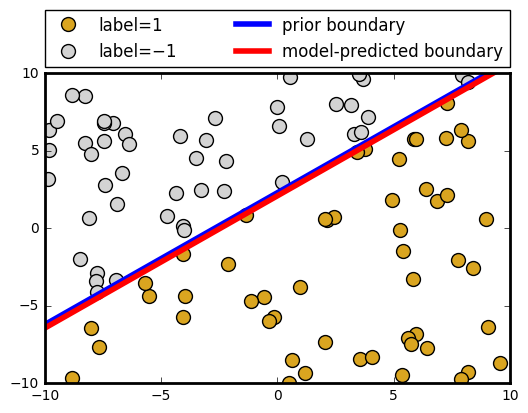

In [8]:
## compare the model-predicted boundary with the prior boundary - for 2D only
if Dd==2:
    compbound_color = 'red'
    # plot points with different labels
    plt.plot(Train_Data[pos_id,1], Train_Data[pos_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=pos_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label='label=1')
    plt.plot(Train_Data[neg_id,1], Train_Data[neg_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=neg_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label=u'label=\u22121')
    # plot the prior boundary
    y_prbound = -1.0 * (p_param[0] + p_param[1]*x_bound) / p_param[2]
    plt.plot(x_bound, y_prbound, color=prbound_color, linestyle=bound_linestyle, 
             linewidth=bound_linewdith, label='prior boundary')
    # plot the model-predicted boundary
    y_compbound = -1.0 * (w_param_steps[-1][0] + w_param_steps[-1][1]*x_bound) / w_param_steps[-1][2]
    plt.plot(x_bound, y_compbound, color=compbound_color, linestyle=bound_linestyle, 
             linewidth=bound_linewdith, label='model-predicted boundary')
    # limits and label
    plt.xlim([-Rd, Rd])
    plt.ylim([-Rd, Rd])
    # legend
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, numpoints=1, mode="expand", borderaxespad=0.)

<a id='section3.4'></a>
### 3.4 Convergence Movie
Define a function to plot a movie of the model-predicted boundaries as a function of iterations.

In [9]:
## movie for all the boundary parameter
def modelbound_movie(Train_Data, Train_Label, w_param_steps, conv_flag, movie_path='./perceptron_conv.mp4'):
    ''' Generate a movie to record each step of boundary parameters during iterations of perceptrons
    '''
    # figure set up
    figure, ax = plt.subplots(figsize=(10,8)) 
    # marker geometry
    marker = 'o'
    markersize = 10
    markeredgewidth = 1
    # colors
    pos_color = 'goldenrod'
    neg_color = 'lightgrey'
    edgecolor = 'k'
    # lines
    marker_linestyle = 'None'
    bound_linestyle = '-'
    bound_linewdith = 4
    prbound_color = 'blue'
    # plot points with different labels
    pos_id = np.where(Train_Label==1)[0]
    plt.plot(Train_Data[pos_id,1], Train_Data[pos_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=pos_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label='label=1')
    neg_id = np.where(Train_Label==-1)[0]
    plt.plot(Train_Data[neg_id,1], Train_Data[neg_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=neg_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label=u'label=\u22121')
    # plot the prior boundary
    x_bound = np.linspace(-Rd, Rd,2)
    y_prbound = -1.0 * (p_param[0] + p_param[1]*x_bound) / p_param[2]
    plt.plot(x_bound, y_prbound, color=prbound_color, linestyle=bound_linestyle, 
             linewidth=bound_linewdith, label='prior boundary')
    # plot the model-output boundary at each time
    pltmodel_list = []
    N_eff_iter = len(w_param_steps)
    for index_frame in range(0,N_eff_iter):
        y_bound_step = -1.0 * (w_param_steps[index_frame][0] + 
                               w_param_steps[index_frame][1]*x_bound) / w_param_steps[index_frame][2]
        plt_modelbound = plt.plot(x_bound, y_bound_step, color=compbound_color, linestyle=bound_linestyle, 
                                  linewidth=bound_linewdith)
        pltmodel_list.append(plt_modelbound)
    # limits and label
    plt.xlim([-Rd, Rd])
    plt.ylim([-Rd, Rd])
    # legend
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, numpoints=1, 
               mode="expand", borderaxespad=0.,fontsize=18)
    # title
    if conv_flag==True:
        title_text = 'Convergence with %d effective iterations'%(N_eff_iter)
    else:
        title_text = 'Non-Convergence with the first %d effective iterations'%(N_eff_iter)
    plt.title(title_text, y=-0.1, fontsize=20)
    
    # start animation
    movie = animation.ArtistAnimation(figure, pltmodel_list, interval=200, blit=True, repeat_delay=1000)
    movie.save(movie_path)
    return movie
# --

Here I show the movie for the above model predictions (The movie could run in jupyter notebook in local PC not GitHub).

In [10]:
conv_movie_path = './perceptron_conv.mp4'
print("- ZJ's message for GitHub viewer - The movie is visible upon downloading...\n- Movie name: %s \n"%(conv_movie_path))
movie = modelbound_movie(Train_Data, Train_Label, w_param_steps, conv_flag, movie_path=conv_movie_path)
plt.close()  # prevent showing the figure by calling "movie", I'd like to show a movie using the following line
HTML(movie.to_html5_video())

- ZJ's message for GitHub viewer - The movie is visible upon downloading...
- Movie name: ./perceptron_conv.mp4 



## 4. Investigations
Here I investigate the following few points about the performance of perceptrons.

### 4.1 Perceptron performance with the XOR training data
In order to investigate if perceptrons are able to handle the training data that are not linearly separable, I revise the pre-defined labels for training data and rerun the perceptron models. As a quick revision, I keep the total number of points with $1$ and $-1$ labels, respectively, but change the orders of their labels. 

In [11]:
## Revisions of training labels
# find number of "1" label points
num_pos = len(pos_id)
Train_Label_XOR = np.ones_like(Train_Label) * np.nan
Train_Label_XOR[:num_pos] = 1
Train_Label_XOR[num_pos:] = -1

We notice that the perceptron will not find the solution after endless iterations. For such kind of issue, we could use the **voted perceptrons** if we must need an answer (Freund and Schapire 1998).

In [12]:
## run perceptrons for the revised training data
w_param_XORsteps, conv_XORflag, _ = perceptron(Train_Data, Train_Label_XOR)
## show the movie 
XOR_movie_path = './perceptron_XOR.mp4'
print("- ZJ's message for GitHub viewer - The movie is visible upon downloading...\n- Movie name: %s \n"%(XOR_movie_path))
movie_XOR = modelbound_movie(Train_Data, Train_Label_XOR, w_param_XORsteps, conv_XORflag, movie_path=XOR_movie_path)
plt.close()  # prevent showing the figure by calling "movie", I'd like to show a movie using the following line
HTML(movie_XOR.to_html5_video())

(ZJ-Style) Error: Perceptrons cannot convergent - data are not linearly separable...
- ZJ's message for GitHub viewer - The movie is visible upon downloading...
- Movie name: ./perceptron_XOR.mp4 



<a id='section4.2'></a>
### 4.2 Convergence Theorem
If the training data are linearly spearable, then the perceptron will converge after updating the boundary parameter $\boldsymbol{w}$ by a finite number of times. Here we could provide the maximum iteration times that are needed given the training data that we just generated.

For simplicity, I denote the following quantities:
<br>
1) $c$: learning rate
<br>
2) $M = \max\limits_{j \in [1,D_{d}]} \left\lVert \boldsymbol{x_{j}}\right\rVert^{2}$: the maximum squared 2-norm among all vectors in the training data
<br>
3) $\mu = \min\limits_{j \in [1,D_{d}]} \left(\boldsymbol{w_{0}} \cdot \boldsymbol{x_{j}} \right)$: the minimum dot product between the initial weight and vectors among the training data. *Unless the initialzied boundary could exactly separate the datasets with two labels, $\mu$ is always a negative value.*
<br>
4) $a = \min\limits_{j \in [1,D_{d}]} l_{j} \left( \boldsymbol{p} \cdot \boldsymbol{x_{j}} \right)$: the minimum dot product between the true boundary $\boldsymbol{p}$ (though the "true" boundary is not necessarily unique) and vectors among the training data, multiplied by labels.

With all the above quantities, we can compute the maximum number of updates (or effective iterations) $N_{\rm conv}$ of the perceptron
$$
N_{\rm conv} = \frac{cM - \mu}{ca^{2}} \left\lVert \boldsymbol{p}\right\rVert^{2}
$$
The above equation is adapted from Robert Snapp's slides of ["The Perceptron Convergence Theorem"](http://www.cems.uvm.edu/~rsnapp/teaching/cs295ml/notes/perceptron.pdf).

In [13]:
def Nconv_perceptron(Train_Data, Train_Label, true_param, learn_rate, w_param_init):
    ''' compute the maximum effective iterations (number of times that the boudnary parameter is updated)
    
    >>> Input:
    - training data and labels
    - true_param:
        the boundary parameter that is used to generate the training data
    - learn_rate:
        learning rate of the perceptron
    - w_param_init:
        the initial boundary parameter
        
    >>> Output:
    - the expected maximum number of iterations till convergence
    '''
    # compute M
    conv_M = np.max(np.sum(Train_Data**2, axis=1))
    # compute mu
    conv_mu = np.min(np.sum(Train_Data * w_param_init, axis=1))
    # compute a
    conv_a = np.min(Train_Label * np.sum(Train_Data * true_param, axis=1))
    return (learn_rate * conv_M - conv_mu)/(learn_rate * conv_a**2) * np.sum(true_param**2)

<a id='section4.3'></a>
### 4.3 Perceptron performance with different initial boundary and learning rates
In order to investigate the performance of perceptrons with different initial boundary parameters, as well as learning rates, I generate a large number of ensembles with different initial conditions. I run the perceptron for each ensemble in order to obtain the following quantities:
<br>
(1) $N_{\rm iter,total}$: total number of iterations
<br>
(2) $N_{\rm iter,eff}$: number of iterations that update the boundary parameter
<br>
(3) $N_{\rm conv}$: the expected maximum iteration numbers to reach convergence
<br>
(4) Weights: the final model-predicted boundary for each ensemble

The ensembles are generated with $N_{\rm init}$ initializations and $N_{\rm Rlearn}$ different learning rates.

In [14]:
# Here I build up the perceptron again, by including more components
### Basic settings
# number of initializations of the boundary parameters
N_init = 100
# list of learning rates
Rlearn_bound = [-4,2]
Rlearn_num = 20
Rlearn = 10**(np.linspace(Rlearn_bound[0], Rlearn_bound[-1], Rlearn_num))
# empty arrays to save the total iterations, the number of iterations till convergence, and the final weights
Niter_total = np.ones((N_init, Rlearn_num)) * np.nan
Niter_eff = np.ones((N_init, Rlearn_num)) * np.nan
Nconv = np.ones((N_init, Rlearn_num)) * np.nan
Weights = np.ones((N_init, Rlearn_num, Dd+1)) * np.nan
### Start each ensemble
for index_init in range(0,N_init):
    # initialize the boundary parameter
    w_param_init = np.random.uniform(low=p_bound[0], high=p_bound[-1], size=Dd+1)
    # scan each learning rate
    for index_learn in range(0,Rlearn_num):
        # run perceptrons
        w_param_steps, conv_flag, N_iter = perceptron(Train_Data, Train_Label, 
                                                      learn_rate=Rlearn[index_learn], w_param_init=w_param_init)
        # expected iterations till convergence
        Niter_total[index_init, index_learn] = N_iter
        Niter_eff[index_init, index_learn] = len(w_param_steps)
        Nconv[index_init, index_learn] = Nconv_perceptron(Train_Data, Train_Label, 
                                                          p_param, Rlearn[index_learn], w_param_init)
        Weights[index_init, index_learn] = w_param_steps[-1]

<a id='section4.3.1'></a>
#### 4.3.1 $N_{\rm iter,total}$ vs. $R_{\rm learn}$
Here I plot the $N_{\rm iter,total}$ as a function of $R_{\rm learn}$, with different initialized boundary parameter $\boldsymbol{w}$ (*black*). For simplicity, I normalize the $N_{\rm iter,max}$ as
$$
\frac{N_{\rm iter,total} - N_{\rm d}}{N_{\rm d}}
$$
I subtract $N_{\rm d}$ from $N_{\rm iter,total}$ because the first $N_{\rm iter,total}$ iterations are mandatory for all sets of data. Or put it in other words, the model need to scan through each data point to check if it could give a correct label.

As we can see, while the $N_{\rm iter,total}$ on average decrease with the learning rate, a fraction of ensembles give relatively smaller total iterations with learning rates of $\approx 0.1-1.0$.

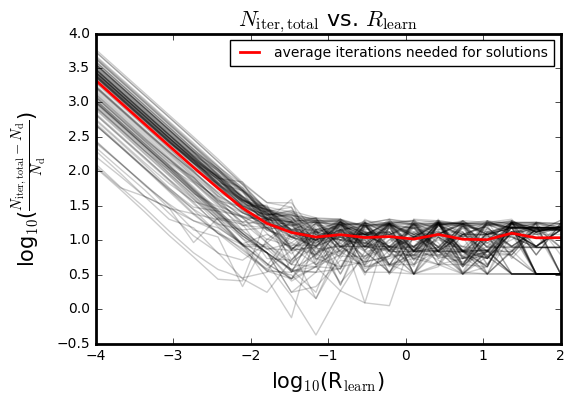

In [15]:
# N_iter_total vs. R_learn
for index_init in range(0,N_init):
    plt.plot(np.log10(Rlearn), np.log10((Niter_total[index_init]-Nd)/Nd), linewidth=1, color='k', alpha=0.2)
    plt.xlabel(r'log$_{10}$(R$_{\rm learn}$)',fontsize=15)
    plt.ylabel(r'log$_{10}$($\frac{N_{\rm iter,total} - N_{\rm d}}{N_{\rm d}}$)',fontsize=15)
# plot the mean maximum interation number among all ensembles
Mean_Niter_total = np.mean(Niter_total, axis=0)
plt.plot(np.log10(Rlearn), np.log10((Mean_Niter_total-Nd)/Nd), linewidth=2, color='red', alpha=1, 
        label='average iterations needed for solutions')
# add a legend
plt.legend(loc='upper right', fontsize=10)
# add a title
plt.title(r'$N_{\rm iter,total}$ vs. $R_{\rm learn}$', fontsize=16)

<a id='section4.3.2'></a>
#### 4.3.2 $N_{\rm conv}$ vs. $R_{\rm learn}$
I also show the relation between the expected iteration number till convergence and the learning rate $R_{\rm learn}$. In principle, we could derive their relation based on the equation in [Section 4.2](#section4.2), where I obtain
$$
N_{\rm conv} = \frac{M}{a^{2}}\left\lVert \boldsymbol{p}\right\rVert^{2} - \left(\frac{\mu}{a^{2}}\left\lVert \boldsymbol{p}\right\rVert^{2}\right) \frac{1}{c}
$$
where $\mu$ is a negative value (unless the initialized boundary could exactly separate the datasets with two labels). Therefore the above equation tells us that the expected iterations till convergence decrease with learning rate, which is intuitively reasonable given that the faster the perceptron learn (higher learning rate), the less iterations it need to reach convergence. The relation between $N_{\rm conv}$ vs. $R_{\rm learn}$ could be expressed by the following figure.

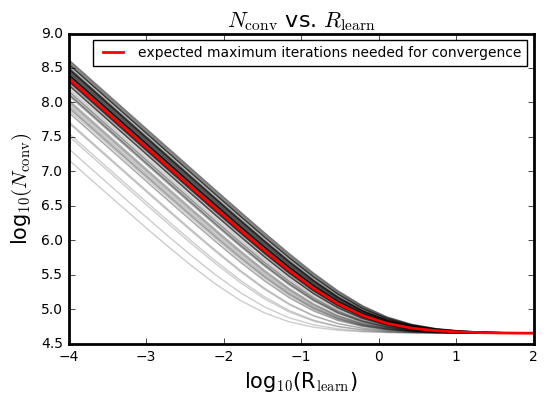

In [16]:
# N_conv vs. R_learn
for index_init in range(0,N_init):
    plt.plot(np.log10(Rlearn), np.log10(Nconv[index_init]), linewidth=1, color='k', alpha=0.2)
    plt.xlabel(r'log$_{10}$(R$_{\rm learn}$)',fontsize=15)
    plt.ylabel(r'log$_{10}(N_{\rm conv})$',fontsize=15)
# plot the mean maximum interation number among all ensembles
Mean_Nconv = np.mean(Nconv, axis=0)
plt.plot(np.log10(Rlearn), np.log10(Mean_Nconv), linewidth=2, color='red', alpha=1, 
        label='expected maximum iterations needed for convergence')
# add a legend
plt.legend(loc='upper right', fontsize=10)
# add a title
plt.title(r'$N_{\rm conv}$ vs. $R_{\rm learn}$', fontsize=16)

<a id='section4.4'></a>
### 4.4 Model-predicted boundaries with different initial conditions
Given the training data generated with different initial $\boldsymbol{w}$ and trained with different learning rate $R_{\rm learn}$, I compare the model-predicted boundaries based on perceptrons. By plotting all of the output boundaries from the pre-defined ensembles, I could obtain a bunch of boundaries that could separate the training data. Most ensembles predict the boundaries with very similar parameters while there are several "outliers" which also works. If the number of ensembles are large enough, then the *red shades* describe the posterior distributions of the boundary parameters.

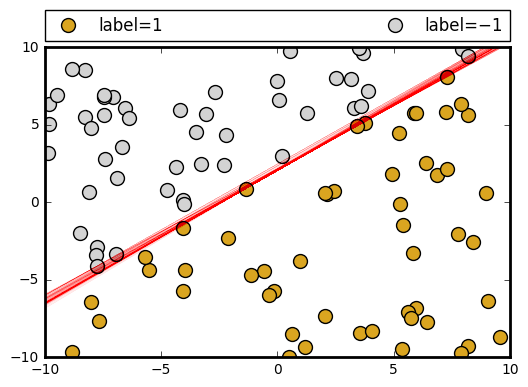

In [17]:
## compare model-predicted boundaries
if Dd==2:
    # plot points with different labels
    plt_label_pos, = plt.plot(Train_Data[pos_id,1], Train_Data[pos_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=pos_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label='label=1')
    plt_label_neg, = plt.plot(Train_Data[neg_id,1], Train_Data[neg_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=neg_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label=u'label=\u22121')
    # plot the model-predicted boundary
    for index_init in range(0,N_init):
        for index_learn in range(0,Rlearn_num): 
            weight_element = Weights[index_init, index_learn]
            y_compbound = -1.0 * (weight_element[0] + weight_element[1]*x_bound) / weight_element[2]
            plt_modelbound, = plt.plot(x_bound, y_compbound, color='red', linestyle=bound_linestyle, 
                     linewidth=bound_linewdith/100, alpha=0.05)
    # limits and label
    plt.xlim([-Rd, Rd])
    plt.ylim([-Rd, Rd])
    # legend
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, numpoints=1, mode="expand", borderaxespad=0.)